In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import xarray as xr
import imageio
import os


In [2]:
def plot_tmmx(day,ax):
  # Open the NetCDF file
    file_path = '../../data/tmmx.nc'  # Update with your NetCDF file path
    dataset = xr.open_dataset(file_path)

    # Assume 'lat', 'lon', and 'precipitation_amount' are the variable names in your NetCDF file
    latitudes = dataset['lat'].values
    longitudes = dataset['lon'].values
    # req_thing = 'precipitation_amount'

    req_thing = 'air_temperature'
    t_max = dataset.variables[req_thing].values  # Adjust according to your file
    t_max_celsius=t_max-273.15
    # Select a specific time step (for example, the first time step)
    t_max_slice= t_max_celsius[day, :, :]  # Select the first time step

    # Ensure latitudes and longitudes are 1D arrays and precipitation_slice is 2D
    # print('Latitudes shape:', latitudes.shape)
    # print('Longitudes shape:', longitudes.shape)
    # print('Temperature slice shape:', t_max_slice.shape)
    
    # Create a Basemap instance
    # #plt.figure(figsize=(4, 4))
    m = Basemap(projection='lcc', resolution='i',
                lat_0=37.5, lon_0=-96,
                llcrnrlon=-119, urcrnrlon=-64,
                llcrnrlat=22, urcrnrlat=50)

    # Draw coastlines and countries
    m.drawcoastlines()
    m.drawcountries()

    # Convert lat/lon to map projection coordinates
    dx = np.diff(longitudes)[0]/2.0
    dy = np.diff(latitudes)[0]/2.0
    lon_edges = np.concatenate([[longitudes[0] - dx], longitudes + dx])
    lat_edges = np.concatenate([[latitudes[0] - dy], latitudes + dy])
        
        # Convert lat/lon to map projection coordinates
    lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)
    x, y = m(lon_grid, lat_grid)
    vmin = 15
    vmax = 50
    # Create color map using pcolormesh
    mesh = m.pcolormesh(x, y, t_max_slice, cmap='YlOrRd', shading='auto', vmin=vmin, vmax=vmax, ax=ax)


    # Add colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Temperature (°C)')

    # Add title
    #ax.set_title('Maximum Near-Surface Air Temperature over the USA')

    # Show the plot
    # plt.show()

    # Close the dataset
    dataset.close()

In [3]:
def plot_tmmn(day,ax):
  # Open the NetCDF file
    file_path = '../../data/tmmn.nc'  # Update with your NetCDF file path
    dataset = xr.open_dataset(file_path)

    # Assume 'lat', 'lon', and 'precipitation_amount' are the variable names in your NetCDF file
    latitudes = dataset['lat'].values
    longitudes = dataset['lon'].values
    # req_thing = 'precipitation_amount'

    req_thing = 'air_temperature'
    t_max = dataset.variables[req_thing].values  # Adjust according to your file
    t_max_celsius=t_max-273.15
    # Select a specific time step (for example, the first time step)
    t_max_slice= t_max_celsius[day, :, :]  # Select the first time step

    # Ensure latitudes and longitudes are 1D arrays and precipitation_slice is 2D
    # print('Latitudes shape:', latitudes.shape)
    # print('Longitudes shape:', longitudes.shape)
    # print('Temperature slice shape:', t_max_slice.shape)
    
    # Create a Basemap instance
    # #plt.figure(figsize=(4, 4))
    m = Basemap(projection='lcc', resolution='i',
                lat_0=37.5, lon_0=-96,
                llcrnrlon=-119, urcrnrlon=-64,
                llcrnrlat=22, urcrnrlat=50)

    # Draw coastlines and countries
    m.drawcoastlines()
    m.drawcountries()

    # Convert lat/lon to map projection coordinates
    dx = np.diff(longitudes)[0]/2.0
    dy = np.diff(latitudes)[0]/2.0
    lon_edges = np.concatenate([[longitudes[0] - dx], longitudes + dx])
    lat_edges = np.concatenate([[latitudes[0] - dy], latitudes + dy])
        
        # Convert lat/lon to map projection coordinates
    lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)
    x, y = m(lon_grid, lat_grid)
    # Create color map using pcolormesh
    mesh = m.pcolormesh(x, y, t_max_slice, cmap='YlOrRd_r', shading='auto', ax=ax)


    # Add colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Temperature (°C)')

    # Add title
    #ax.set_title('Maximum Near-Surface Air Temperature over the USA')

    # Show the plot
    # plt.show()

    # Close the dataset
    dataset.close()

In [4]:
def plot_srad(day,ax):
  # Open the NetCDF file
    file_path = '../../data/srad.nc'  # Update with your NetCDF file path
    dataset = xr.open_dataset(file_path)
    latitudes = dataset['lat'].values
    longitudes = dataset['lon'].values
    req_thing = 'surface_downwelling_shortwave_flux_in_air'
    t_max = dataset.variables[req_thing].values  # Adjust according to your file
    t_max_slice= t_max[day, :, :]  # Select the first time step

    # Ensure latitudes and longitudes are 1D arrays and precipitation_slice is 2D
    # print('Latitudes shape:', latitudes.shape)
    # print('Longitudes shape:', longitudes.shape)
    # print('Temperature slice shape:', t_max_slice.shape)
    
    # Create a Basemap instance
    #plt.figure(figsize=(4, 4))
    m = Basemap(projection='lcc', resolution='i',
                lat_0=37.5, lon_0=-96,
                llcrnrlon=-119, urcrnrlon=-64,
                llcrnrlat=22, urcrnrlat=50)

    # Draw coastlines and countries
    m.drawcoastlines()
    m.drawcountries()

    # Convert lat/lon to map projection coordinates
    dx = np.diff(longitudes)[0]/2.0
    dy = np.diff(latitudes)[0]/2.0
    lon_edges = np.concatenate([[longitudes[0] - dx], longitudes + dx])
    lat_edges = np.concatenate([[latitudes[0] - dy], latitudes + dy])
        
        # Convert lat/lon to map projection coordinates
    lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)
    x, y = m(lon_grid, lat_grid)
    # Create color map using pcolormesh
    mesh = m.pcolormesh(x, y, t_max_slice, cmap='YlOrRd_r', shading='auto', ax=ax)


    # Add colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('SRAD')

    # Add title
    #ax.se_title('SRAD')

    # Show the plot
    plt.show()

    # Close the dataset
    dataset.close()

In [5]:
def plot_bi(day,ax):
  # Open the NetCDF file
    file_path = '../../data/bi.nc'  # Update with your NetCDF file path
    dataset = xr.open_dataset(file_path)
    latitudes = dataset['lat'].values
    longitudes = dataset['lon'].values
    req_thing = 'burning_index_g'
    t_max = dataset.variables[req_thing].values  # Adjust according to your file
    t_max_slice= t_max[day, :, :]  # Select the first time step

    # Ensure latitudes and longitudes are 1D arrays and precipitation_slice is 2D
    # print('Latitudes shape:', latitudes.shape)
    # print('Longitudes shape:', longitudes.shape)
    # print('Temperature slice shape:', t_max_slice.shape)
    
    # Create a Basemap instance
    #plt.figure(figsize=(4, 4))
    m = Basemap(projection='lcc', resolution='i',
                lat_0=37.5, lon_0=-96,
                llcrnrlon=-119, urcrnrlon=-64,
                llcrnrlat=22, urcrnrlat=50)

    # Draw coastlines and countries
    m.drawcoastlines()
    m.drawcountries()

    # Convert lat/lon to map projection coordinates
    dx = np.diff(longitudes)[0]/2.0
    dy = np.diff(latitudes)[0]/2.0
    lon_edges = np.concatenate([[longitudes[0] - dx], longitudes + dx])
    lat_edges = np.concatenate([[latitudes[0] - dy], latitudes + dy])
        
        # Convert lat/lon to map projection coordinates
    lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)
    x, y = m(lon_grid, lat_grid)
    # Create color map using pcolormesh
    mesh = m.pcolormesh(x, y, t_max_slice, cmap='YlOrRd_r', shading='auto', ax=ax)


    # Add colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('BI')

    # Add title
    #ax.se_title('SRAD')

    # Show the plot
    plt.show()

    # Close the dataset
    dataset.close()

In [6]:
def plot_erc(day,ax):
  # Open the NetCDF file
    file_path = '../../data/erc.nc'  # Update with your NetCDF file path
    dataset = xr.open_dataset(file_path)
    latitudes = dataset['lat'].values
    longitudes = dataset['lon'].values
    req_thing = 'energy_release_component-g'
    t_max = dataset.variables[req_thing].values  # Adjust according to your file
    t_max_slice= t_max[day, :, :]  # Select the first time step

    # Ensure latitudes and longitudes are 1D arrays and precipitation_slice is 2D
    # print('Latitudes shape:', latitudes.shape)
    # print('Longitudes shape:', longitudes.shape)
    # print('Temperature slice shape:', t_max_slice.shape)
    
    # Create a Basemap instance
    #plt.figure(figsize=(4, 4))
    m = Basemap(projection='lcc', resolution='i',
                lat_0=37.5, lon_0=-96,
                llcrnrlon=-119, urcrnrlon=-64,
                llcrnrlat=22, urcrnrlat=50)

    # Draw coastlines and countries
    m.drawcoastlines()
    m.drawcountries()

    # Convert lat/lon to map projection coordinates
    dx = np.diff(longitudes)[0]/2.0
    dy = np.diff(latitudes)[0]/2.0
    lon_edges = np.concatenate([[longitudes[0] - dx], longitudes + dx])
    lat_edges = np.concatenate([[latitudes[0] - dy], latitudes + dy])
        
        # Convert lat/lon to map projection coordinates
    lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)
    x, y = m(lon_grid, lat_grid)
    # Create color map using pcolormesh
    mesh = m.pcolormesh(x, y, t_max_slice, cmap='YlOrRd_r', shading='auto', ax=ax)


    # Add colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('ERC')

    # Add title
    #ax.se_title('SRAD')

    # Show the plot
    plt.show()

    # Close the dataset
    dataset.close()

In [7]:
def plot_fm100(day,ax):
  # Open the NetCDF file
    file_path = '../../data/fm100.nc'  # Update with your NetCDF file path
    dataset = xr.open_dataset(file_path)
    latitudes = dataset['lat'].values
    longitudes = dataset['lon'].values
    req_thing = 'dead_fuel_moisture_100hr'
    t_max = dataset.variables[req_thing].values  # Adjust according to your file
    t_max_slice= t_max[day, :, :]  # Select the first time step

    # Ensure latitudes and longitudes are 1D arrays and precipitation_slice is 2D
    # print('Latitudes shape:', latitudes.shape)
    # print('Longitudes shape:', longitudes.shape)
    # print('Temperature slice shape:', t_max_slice.shape)
    
    # Create a Basemap instance
    #plt.figure(figsize=(4, 4))
    m = Basemap(projection='lcc', resolution='i',
                lat_0=37.5, lon_0=-96,
                llcrnrlon=-119, urcrnrlon=-64,
                llcrnrlat=22, urcrnrlat=50)

    # Draw coastlines and countries
    m.drawcoastlines()
    m.drawcountries()

    # Convert lat/lon to map projection coordinates
    dx = np.diff(longitudes)[0]/2.0
    dy = np.diff(latitudes)[0]/2.0
    lon_edges = np.concatenate([[longitudes[0] - dx], longitudes + dx])
    lat_edges = np.concatenate([[latitudes[0] - dy], latitudes + dy])
        
        # Convert lat/lon to map projection coordinates
    lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)
    x, y = m(lon_grid, lat_grid)
    # Create color map using pcolormesh
    mesh = m.pcolormesh(x, y, t_max_slice, cmap='YlOrRd_r', shading='auto', ax=ax)


    # Add colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('FM100')

    # Add title
    #ax.se_title('SRAD')

    # Show the plot
    plt.show()

    # Close the dataset
    dataset.close()

In [8]:
def plot_fm1000(day,ax):
  # Open the NetCDF file
    file_path = '../../data/fm1000.nc'  # Update with your NetCDF file path
    dataset = xr.open_dataset(file_path)
    latitudes = dataset['lat'].values
    longitudes = dataset['lon'].values
    req_thing = 'dead_fuel_moisture_1000hr'
    t_max = dataset.variables[req_thing].values  # Adjust according to your file
    t_max_slice= t_max[day, :, :]  # Select the first time step

    # Ensure latitudes and longitudes are 1D arrays and precipitation_slice is 2D
    # print('Latitudes shape:', latitudes.shape)
    # print('Longitudes shape:', longitudes.shape)
    # print('Temperature slice shape:', t_max_slice.shape)
    
    # Create a Basemap instance
    #plt.figure(figsize=(4, 4))
    m = Basemap(projection='lcc', resolution='i',
                lat_0=37.5, lon_0=-96,
                llcrnrlon=-119, urcrnrlon=-64,
                llcrnrlat=22, urcrnrlat=50)

    # Draw coastlines and countries
    m.drawcoastlines()
    m.drawcountries()

    # Convert lat/lon to map projection coordinates
    dx = np.diff(longitudes)[0]/2.0
    dy = np.diff(latitudes)[0]/2.0
    lon_edges = np.concatenate([[longitudes[0] - dx], longitudes + dx])
    lat_edges = np.concatenate([[latitudes[0] - dy], latitudes + dy])
        
        # Convert lat/lon to map projection coordinates
    lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)
    x, y = m(lon_grid, lat_grid)
    # Create color map using pcolormesh
    mesh = m.pcolormesh(x, y, t_max_slice, cmap='YlOrRd_r', shading='auto', ax=ax)


    # Add colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('FM1000')

    # Add title
    #ax.se_title('SRAD')

    # Show the plot
    plt.show()

    # Close the dataset
    dataset.close()

In [9]:
def save_tmmx_plots(start_day=0, end_day=91, output_dir='tmmx_plots'):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Loop through days
    for day in range(start_day, end_day + 1):
        print(f'Processing day {day}...')
        
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Use existing plot function
        plot_tmmx(day, ax)
        
        # Save the plot
        plt.savefig(os.path.join(output_dir, f'fm1000_day_{day:03d}.png'), 
                    dpi=300, bbox_inches='tight')
        
        # Clear the figure to free memory
        plt.close(fig)
        
    print('All plots generated successfully!')

In [10]:
save_tmmx_plots(67)

Processing day 67...
Processing day 68...
Processing day 69...
Processing day 70...
Processing day 71...
Processing day 72...
Processing day 73...
Processing day 74...
Processing day 75...
Processing day 76...
Processing day 77...
Processing day 78...
Processing day 79...
Processing day 80...
Processing day 81...
Processing day 82...
Processing day 83...
Processing day 84...
Processing day 85...
Processing day 86...
Processing day 87...
Processing day 88...
Processing day 89...
Processing day 90...
Processing day 91...
All plots generated successfully!


In [11]:
file_path = '../../data/fm1000.nc'  # Update with your NetCDF file path
dataset = xr.open_dataset(file_path)
dataset.keys()

KeysView(<xarray.Dataset> Size: 597MB
Dimensions:                    (lon: 1386, lat: 585, day: 92, crs: 1)
Coordinates:
  * lon                        (lon) float64 11kB -124.8 -124.7 ... -67.1 -67.06
  * lat                        (lat) float64 5kB 49.4 49.36 ... 25.11 25.07
  * day                        (day) datetime64[ns] 736B 2021-06-01 ... 2021-...
  * crs                        (crs) uint16 2B 3
Data variables:
    dead_fuel_moisture_1000hr  (day, lat, lon) float64 597MB ...
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       30 March 2023
    note1:                      The projection information for this file is: ...
    note2:    

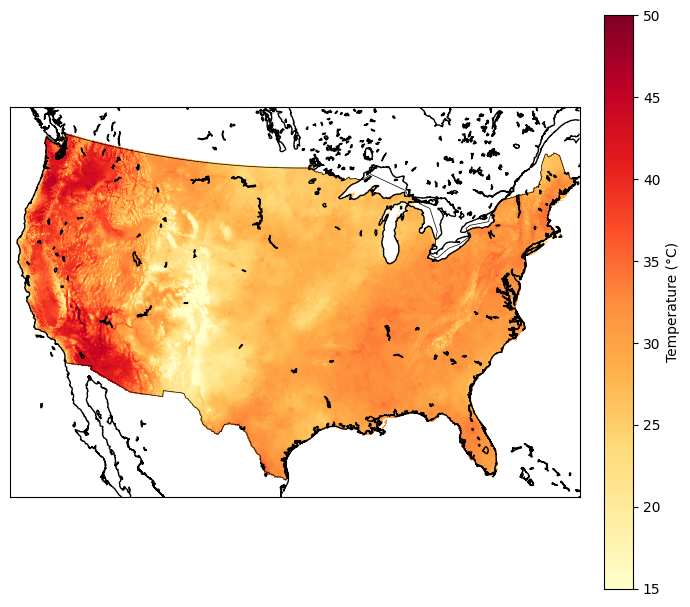

In [12]:
# fig, axes = plt.subplots(1, 3, figsize=(21, 8))

day = 27
# plot_tmmx(day, axes[0])  # Plot in the first box
# plot_tmmn(day, axes[1])  # Plot in the second box
# plot_srad(day, axes[2])   # Plot in the third box

# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(1, 1, figsize=(7, 8))
# plot_fm100(day, axes)   # Plot in the fifth box
# plt.tight_layout()
# plt.show()

fig, axes = plt.subplots(1, 1, figsize=(7, 8))
plot_tmmx(day, axes)   # Plot in the fifth box
plt.tight_layout()
plt.show()

# plt.tight_layout()

# plt.show()
# fig, axes = plt.subplots(1, 1, figsize=(7, 8))
# plot_bi(day, axes)   # Plot in the fifth box
# plt.tight_layout()
# plt.show()

# plt.show()
# fig, axes = plt.subplots(1, 1, figsize=(7, 8))
# plot_erc(day, axes)   # Plot in the fifth box
# plt.tight_layout()
# plt.show()


# Turn off the sixth subplot if not needed
# axes[1, 2].axis('off')

# plt.tight_layout()
# plt.show()
